In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from IPython.display import display, HTML

# Datasets for the Course

## Survey Datasets

### Malnutrition in Ethiopia (EDHS2016)

Nutritional insufficiency, is a major health problem among U5 children.
Chronic stunting accounts for various health problems and leading to
different diseases later in adolescents and adults. Prevalence of
stunting for U5 children in Ethiopia was 38.7% (EDHS 2016). Based on WHO
guideline, a child is stunted when a height for age Z-score (HAZ) is \<
$-2SD$. This dataset was extracted from the [Demographic and Health
Survey]{<https://dhsprogram.com/>} 2016 conducted in Ethiopia. The
variable names found in the dataset with their label are the following.

![Table 1: Malnutrition data description](stunting.png) This dataset
used to demonstrate data exploration and modeling techniques under
spatial and non-spatial setting. To demonstrate the advantage of spatial
models over the standard linear model, this dataset further explored in
Chapter XX. The data contain information on the height-for-age score
(HAZ) of `r nrow(read.csv("Stunting2.csv"))` children. HAZ is an
age-standardized measure of the deviation from standard child growth.
Values of HAZ close to zero indicate normal growth, whilst values less
than −2 are interpreted as an indication of stunted growth. Before doing
further analysis, it is common to examine the structure and different
figures of the data under consideration. Table \@ref(tab:data-layout)
and Figure \@ref(fig:HAZ-EDA) helps to uncover the some features of the
data. Table \@ref(tab:data-layout) presents the layout of the data under
consideration.


In [4]:
maln = pd.read_csv("Data/Stunting2.csv")
maln = maln.iloc[:, 0:10]

sampled = maln.sample(10, random_state=42)

caption = "Sample malnutrition data layout extracted from 2016 EDHS"
html_table = sampled.to_html(index=False, justify="center", classes="table table-striped", border=0)

styled_html = f"""
<figure>
    <figcaption style='font-weight:bold; text-align:center; margin-bottom:8px;'>{caption}</figcaption>
    {html_table}
<figure>
"""

display(HTML(styled_html))

cluster,region,residence,education,wealth,sex,stunted,haz,latnum,longnum
318,somali,rural,no education,richer,male,0,2.60,6.467859,42.175358
595,benishangul,rural,primary,richest,female,0,-1.08,10.106709,34.679661
180,snnpr,rural,primary,poorest,male,1,-4.84,6.720108,37.624878
469,gambela,urban,primary,richest,female,0,0.56,8.248008,34.597977
92,somali,rural,primary,poorest,male,0,2.24,6.708449,44.273540
51,afar,rural,no education,poorest,male,1,-2.66,9.282202,40.185783
584,tigray,rural,primary,poorer,female,1,-2.63,14.128922,38.382851
501,harari,rural,no education,richer,female,0,-1.05,9.286125,42.189022
172,afar,rural,no education,poorest,female,0,-0.64,13.248133,40.043686
477,snnpr,rural,no education,poorer,female,0,-1.21,7.173968,35.802681


In [ ]:
eth_bndrs = pd.read_csv("Data/Eth_bndrs.csv")
maln

,cluster,region,residence,education,wealth,sex,stunted,haz,latnum,longnum,waz,utm_x,utm_y,age,hhwealth,meducation
0,1,oromia,rural,no education,poorer,male,1,-2.50,9.505470,42.438629,-2.24,877630.00,1052609.40,2.58,1,1
1,1,oromia,rural,no education,poorer,male,0,0.23,9.505470,42.438629,-0.55,877630.00,1052609.40,3.67,1,1
2,1,oromia,rural,no education,poorer,female,0,2.43,9.505470,42.438629,0.78,877630.00,1052609.40,4.58,1,1
3,1,oromia,rural,no education,poorer,male,1,-2.62,9.505470,42.438629,-3.52,877630.00,1052609.40,0.58,1,1
4,1,oromia,rural,no education,poorer,female,1,-2.21,9.505470,42.438629,-0.80,877630.00,1052609.40,0.08,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,645,addis adaba,urban,no education,richest,male,1,-3.92,8.990524,38.705608,-4.16,467641.22,993817.56,0.00,3,1
8511,645,addis adaba,urban,no education,richest,male,0,-0.12,8.990524,38.705608,0.81,467641.22,993817.56,2.33,3,1
8512,645,addis adaba,urban,primary,richest,male,0,-0.40,8.990524,38.705608,-0.81,467641.22,993817.56,0.08,3,2
8513,645,addis adaba,urban,no education,richest,female,0,1.82,8.990524,38.705608,0.48,467641.22,993817.56,0.42,3,1


In [13]:
eth_bndrs

,utm_x,utm_y
0,407166.1609,1623540.523
1,408452.1522,1623412.862
2,408764.0419,1623447.240
3,409266.1872,1623502.855
4,411145.2994,1623710.274
...,...,...
4637,406278.0784,1624383.944
4638,406769.3557,1623857.139
4639,406896.5760,1623720.781
4640,407004.2071,1623617.200


In [9]:
coords = maln[["utm_x", "utm_y"]].drop_duplicates()
coords

,utm_x,utm_y
0,877630.0000,1052609.40
17,294681.8800,1191865.00
35,817717.0600,1311099.90
51,814583.1300,1061264.30
55,20464.0350,1102266.50
...,...,...
8456,338271.7200,1401515.30
8465,843652.1300,1065514.30
8487,-8546.0947,1025790.30
8498,811257.7500,1062143.60


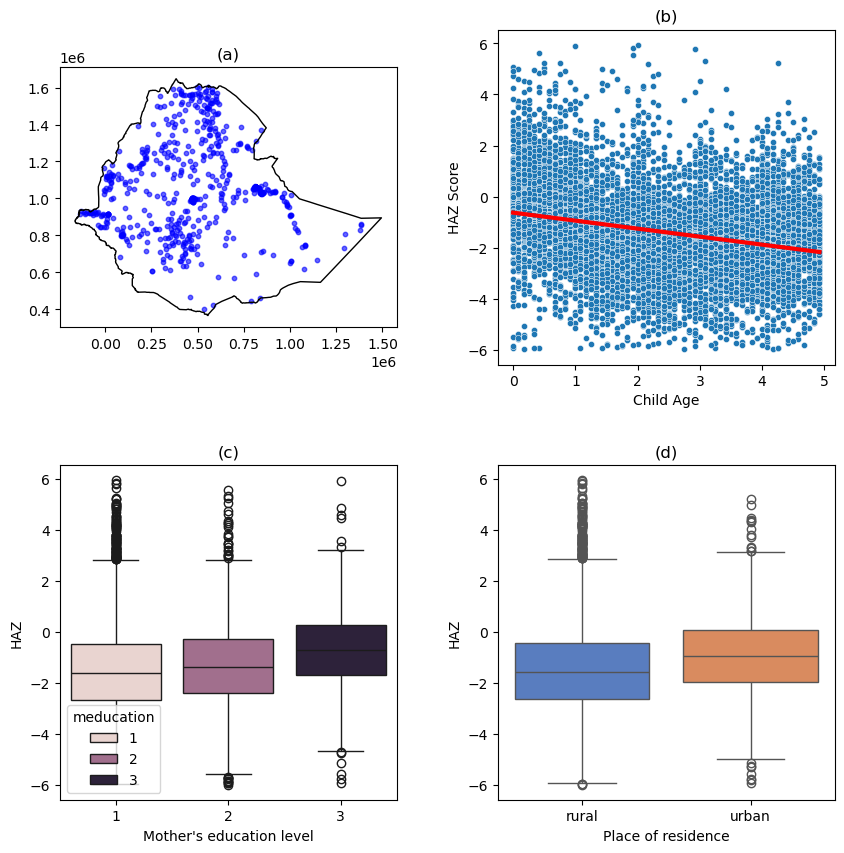

In [23]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# ------------------- (a) Ethiopia map with sample points -------------------
axes[0, 0].plot(eth_bndrs.iloc[:, 0], eth_bndrs.iloc[:, 1], "k-", lw=1)
axes[0, 0].scatter(coords["utm_x"], coords["utm_y"], s=10, color="blue", alpha=0.6)
axes[0, 0].set_aspect('equal')
axes[0, 0].set_title("(a)")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")

# ------------------- (b) Age vs HAZ scatter with regression line -------------------
sns.scatterplot(data=maln, x="age", y="haz", ax=axes[0,1], s=20)
sns.regplot(data=maln, x="age", y="haz", ax=axes[0,1], scatter=False, color="red", line_kws={"lw":3})
axes[0,1].set_title("(b)")
axes[0, 1].set_xlabel("Child Age")
axes[0, 1].set_ylabel("HAZ Score")

# ------------------- (c) HAZ by Mother's education -------------------
sns.boxplot(data=maln, x="meducation", y="haz", ax=axes[1,0], hue="meducation" )
axes[1, 0].set_title("(c)")
axes[1, 0].set_xlabel("Mother's education level")
axes[1, 0].set_ylabel("HAZ")

# ------------------- (d) HAZ by Residence -------------------
sns.boxplot(data=maln, x="residence", y="haz", ax=axes[1,1], hue="residence", palette="muted")
axes[1, 1].set_title("(d)")
axes[1, 1].set_xlabel("Place of residence")
axes[1, 1].set_ylabel("HAZ")

plt.show()

**Further Data Exploration**

The analyst may also interested to explore frequency distribution and
proportions for selected variable as presented below.

In [27]:
# ----------------- 1️⃣ Cross-tabulation -----------------
# Create the contingency table
ctab = pd.crosstab(maln['stunted'], maln['education'])

# Add column percentages
col_perc = ctab.div(ctab.sum(axis=0), axis=1) * 100

# Compute association statistics (Chi², p-value, etc.)
chi2, p, dof, exp = stats.chi2_contingency(ctab)
cramer_v = (chi2 / (ctab.values.sum() * (min(ctab.shape) - 1))) ** 0.5
phi = (chi2 / ctab.values.sum()) ** 0.5

# Display formatted results
html = f"""
<h3>Stunting by Mother's Education Level</h3>
<p><b>Chi²:</b> {chi2:.3f}, <b>p:</b> {p:.4f}, <b>df:</b> {dof}, 
<b>Cramér’s V:</b> {cramer_v:.3f}, <b>Phi:</b> {phi:.3f}</p>
<h4>Column Percentages (%)</h4>
{col_perc.round(2).to_html()}
"""
display(HTML(html))


# ----------------- 2️⃣ Correlation Table -----------------
# Select two numeric columns (like R's c(11,14))
cols = maln.columns[[10, 13]]  # adjust indices if needed
x, y = maln[cols[0]], maln[cols[1]]

# Drop missing values pairwise
df_corr = pd.DataFrame({cols[0]: x, cols[1]: y}).dropna()

# Compute Pearson correlation and p-value
r, p_value = stats.pearsonr(df_corr[cols[0]], df_corr[cols[1]])

# Display correlation results
corr_html = f"""
<h3>Pearson Correlation between {cols[0]} and {cols[1]}</h3>
<table border="1" style="border-collapse: collapse; text-align:center;">
<tr><th>Variable 1</th><th>Variable 2</th><th>r</th><th>p-value</th></tr>
<tr><td>{cols[0]}</td><td>{cols[1]}</td><td>{r:.3f}</td><td>{p_value:.4f}</td></tr>
</table>
"""
display(HTML(corr_html))


education,higher,no education,primary,secondary
stunted,,,,
0,85.76,59.43,65.9,78.39
1,14.24,40.57,34.1,21.61


Variable 1,Variable 2,r,p-value
waz,age,-0.206,0.0000


# Spatial and Statistical Data Exploration in Python

---

## Frequency Distribution and Proportions

In R, we used `table()` and `CrossTable()` from the **gmodels** package.  
In Python, we can achieve this using `pandas.crosstab()` and `value_counts()`.


In [29]:
maln["education"].value_counts()

education
no education    5376
primary         2226
secondary        597
higher           316
Name: count, dtype: int64

In [ ]:
# Cross-tabulation: Wealth vs Stunted
ct = pd.crosstab(maln["wealth"], maln["stunted"])
col_drop = ct.div(ct.sum(axis=0), axis=1).round(2)
row